In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pandas as pd

In [7]:
# --- Set folder and file name ---
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_01_Cross_Section\follow_paper'
file_name = r'E_MS_ground.csv'
file_path = os.path.join(folder, file_name)

# --- Load CSV with header ---
df = pd.read_csv(file_path, header=0)

# --- Determine unit of distance from header ---
distance_label = df.columns[0].lower()
if 'nm' in distance_label:
    unit_scale = 1e-9  # convert nm to meters
    distance_unit = 'nm'
elif 'um' in distance_label or 'μm' in distance_label:
    unit_scale = 1e-6  # convert μm to meters
    distance_unit = 'μm'
else:
    raise ValueError("Unknown distance unit: please include 'nm' or 'um' in the first column header.")

# --- Extract data ---
distance_raw = df.iloc[:, 0].values
distance_m = distance_raw * unit_scale
E_para = df.iloc[:, 1].values
E_perp = df.iloc[:, 2].values

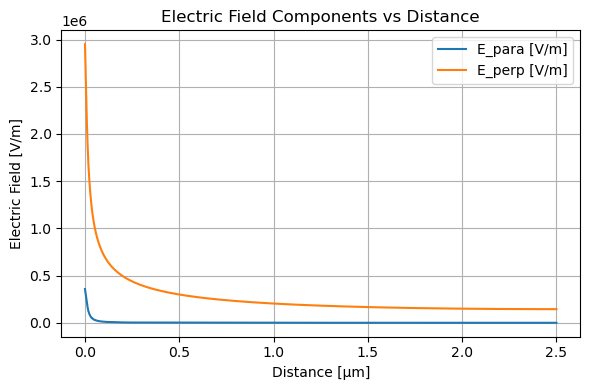

In [8]:
# --- Plot E_para and E_perp vs distance ---
plt.figure(figsize=(6, 4))
plt.plot(distance_raw, E_para, label='E_para [V/m]')
plt.plot(distance_raw, E_perp, label='E_perp [V/m]')
plt.xlabel(f'Distance [{distance_unit}]')
plt.ylabel('Electric Field [V/m]')
plt.title('Electric Field Components vs Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# --- Compute |E|^2 and integrate ---
E_para_sq = np.abs(E_para) ** 2
E_perp_sq = np.abs(E_perp) ** 2

int_E_para_sq = simpson(E_para_sq, x=distance_m)
int_E_perp_sq = simpson(E_perp_sq, x=distance_m)


print(f"∫|E_para|^2 dx = {int_E_para_sq:.4e} V^2·m")
print(f"∫|E_perp|^2 dx = {int_E_perp_sq:.4e} V^2·m")

∫|E_para|^2 dx = 1.2234e+03 V^2·m
∫|E_perp|^2 dx = 3.3067e+05 V^2·m


In [17]:
# Define common parameter
W = 1  # energy per unit length in Joules/m

if 'MA' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_MA = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[MA] Participation Ratio = {int(result_MA * 1e6)} ppm")

elif 'MS' in file_name:
    epsilon_S = 10
    epsilon_MS = 10
    t_MS = 3e-9 # thickness in meters
    result_MS = (epsilon_S ** 2 / epsilon_MS) * int_E_perp_sq * (t_MS / W)
    print(f"[MS] Participation Ratio = {int(result_MS * 1e6)} ppm")

elif 'SA' in file_name:
    epsilon_SA = 10
    t_SA = 3e-9 # thickness in meters
    term_para = epsilon_SA * int_E_para_sq
    term_perp = (1 / epsilon_SA) * int_E_perp_sq
    result_SA = (term_para + term_perp) * (t_SA / W)
    print(f"[SA] Participation Ratio = {int(result_SA * 1e6)} ppm")

elif 'C' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_C = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[C] Participation Ratio = {int(result_C * 1e6)} ppm")

else:
    print("No interface type detected in filename.")

[MS] Participation Ratio = 9920 ppm
